In [5]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d
from numba import njit
import h5py as h5
import os

In [2]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

In [3]:
name = 'MW5iso'

In [110]:
def gas_profile(sn, rmax=300, Rmax=40, dr=1, dR=1, zcut=3, mass_is_dens=False, center=None):
    if center is None:
        center = np.array([sn.BoxSize] * 3)/2.

    pos = sn.part0.pos - center
    r = np.linalg.norm(pos, axis=1)
    R = np.linalg.norm(pos[:,:2], axis=1)
    z = pos[:,1]
    
    rmin = 0
    
    out = {}
    out['rlist'] = []
    out['rholist'] = []
    
    while rmin < rmax:
        key = np.logical_and(r >= rmin, r < rmin + dr)
        aver = np.mean(r[key])
        
        if mass_is_dens:
            rho = np.mean(sn.part0.mass[key])
        else:
            Menc = np.sum(sn.part0.mass[key])
            vol = (4 * np.pi/3.) * ((rmin + dr)**3 - rmin**3)
            rho = Menc / vol
        
        out['rlist'].append(aver)
        out['rholist'].append(rho)
        
        rmin += dr
    
    
    Rmin = 0
    out['Rlist'] = []
    out['sigmalist'] = []
    
    while Rmin < Rmax:
        key = np.logical_and(R >= Rmin, R < Rmin + dR)
        key = np.logical_and(key, np.abs(z) < zcut)
        
        aveR = np.mean(R[key])
        
        Menc = np.sum(sn.part0.mass[key])
        area = np.pi * ((Rmin + dR)**2 - Rmin**2)
        sigma = Menc / vol
        
        out['Rlist'].append(aveR)
        out['sigmalist'].append(sigma)
        
        Rmin += dR
    
    for k in out.keys():
        out[k] = np.array(out[k])
    
    return out

In [111]:
idx_list = np.array([0, 100, 200, 400])#, 600, 800, 1000, 1200, 1400, 1600])
bt_list = ['05', '06', '067', '07', '08']
fields = ['Coordinates', 'Masses', 'Density', 'ElectronAbundance', 'InternalEnergy']
parttype = [0]

sn_dict = {}
prof = {}
for bt in bt_list:
    sn_dict[bt] = {}
    prof[bt] = {}

for idx in tqdm(idx_list):
    for bt in bt_list:
        output_dir = basepath + 'runs/' + name + '/lvl5-beta' + bt + '-adi/output'
        sn_dict[bt][idx] = arepo.Snapshot(output_dir, idx, fields=fields, parttype=parttype,
                                          combineFiles=True)
        prof[bt][idx] = gas_profile(sn_dict[bt][idx], dr=2.0)

100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


(1, 100)

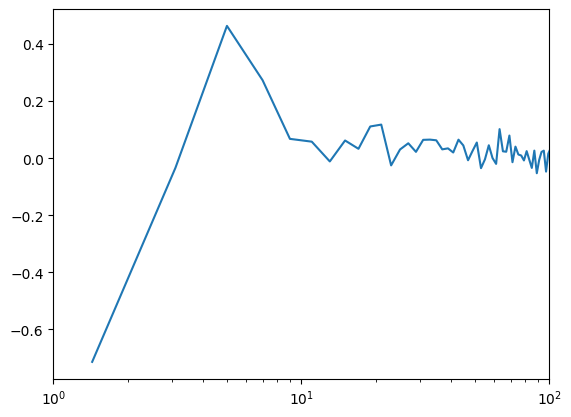

In [123]:
idx = 400
# for bt in bt_list:
for bt in ['067']:
    y = (prof[bt][idx]['rholist'] - prof[bt][0]['rholist'])/prof[bt][0]['rholist']
    plt.plot(prof[bt][idx]['rlist'], y, label=bt)
    # plt.plot(prof[bt][idx]['rlist'], prof[bt][idx]['rholist'])
    # plt.plot(prof[bt][0]['rlist'], prof[bt][0]['rholist'])
    # plt.plot(prof[bt][0]['rlist'], 
    
# plt.legend(frameon=False)
# plt.xlim(20, 129)
plt.xscale('log')
# plt.yscale('log')
# plt.ylim(1e-7, 2e-3)
plt.xlim(1, 100)

In [44]:
idx_list_adi = np.array([0, 50, 100, 150, 200])
fields = ['Coordinates', 'Masses', 'Density', 'ElectronAbundance', 'InternalEnergy']
parttype = [0]

sn_dict_adi = {}
prof_adi = {}
for bt in bt_list:
    sn_dict_adi[bt] = {}
    prof_adi[bt] = {}

for idx in tqdm(idx_list_adi):
    for bt in bt_list:
        output_dir = basepath + 'runs/' + name + '/lvl5-beta' + bt + '-adi/output'
        # if bt=='05' and idx==50:
            # tmp = arepo.Snapshot(output_dir, idx, fields=fields, parttype=parttype,
                                          # combineFiles=True)
            # print(tmp)
        try:
            # print(bt, idx, output_dir)
        # if True:
            sn_dict_adi[bt][idx] = arepo.Snapshot(output_dir, idx, fields=fields, parttype=parttype,
                                          combineFiles=True)
            prof_adi[bt][idx] = gas_profile(sn_dict_adi[bt][idx], dr=2.0)
            print(bt, idx)
        except:
            pass

  0%|                                                                                                                                  | 0/5 [00:00<?, ?it/s]

05 0
06 0
067 0


 20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:01,  2.15it/s]

07 0
08 0
05 50
06 50
067 50


 40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:00<00:01,  2.00it/s]

07 50
08 50


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.10it/s]

05 100


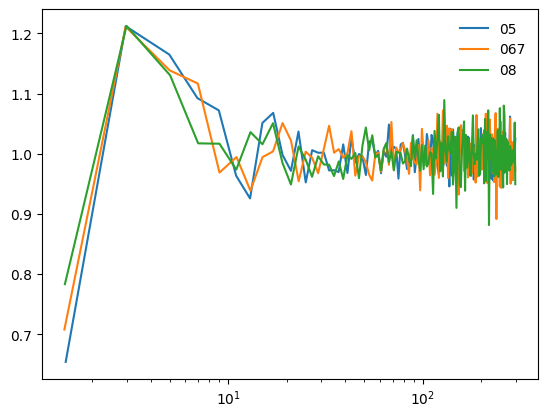

In [46]:
idx = 50
# for bt in bt_list:
for bt in ['05', '067', '08']:
    y = (prof_adi[bt][idx]['rholist'])/prof_adi[bt][0]['rholist']
    plt.plot(prof_adi[bt][idx]['rlist'], y, label=bt)

plt.legend(frameon=False)
# plt.xlim(20, 129)
plt.xscale('log')
# plt.yscale('log')

## softEOS

In [92]:
# idx_list = np.array([0, 100, 200, 400])#, 600, 800, 1000, 1200, 1400, 1600])
idx_list = np.array([0, 1, 2, 4, 50])#, 3, 4])#, 600, 800, 1000, 1200, 1400, 1600])
bt_list = ['05']#, '06', '067', '07', '08']
# fields = ['Coordinates', 'Masses', 'Density', 'ElectronAbundance', 'InternalEnergy']
# parttype = [0]
fields = None
parttype = None

sn_dict = {}
prof = {}
for bt in bt_list:
    sn_dict[bt] = {}
    prof[bt] = {}

for idx in tqdm(idx_list):
    for bt in bt_list:
        output_dir = basepath + 'runs/' + name + '/lvl5-beta' + bt + '-adi-softEOS/output'
        sn_dict[bt][idx] = arepo.Snapshot(output_dir, idx, fields=fields, parttype=parttype,
                                          combineFiles=True)
        prof[bt][idx] = gas_profile(sn_dict[bt][idx], dr=2.0)

100%|██████████| 5/5 [00:01<00:00,  3.48it/s]


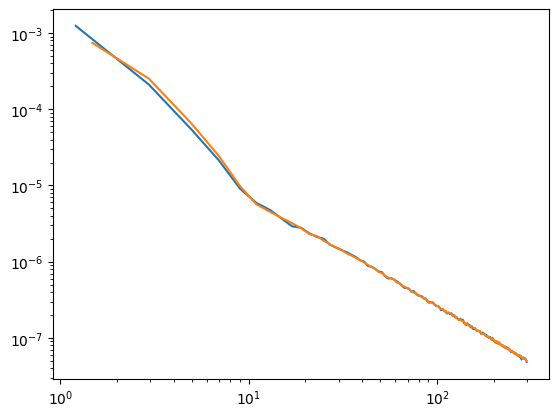

In [93]:
bt = '05'
plt.plot(prof[bt][0]['rlist'], prof[bt][0]['rholist'])
plt.plot(prof[bt][50]['rlist'], prof[bt][50]['rholist'])

plt.xscale('log')
plt.yscale('log')

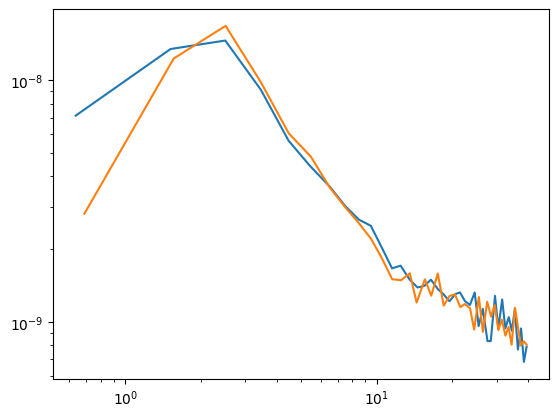

In [94]:
bt = '05'
plt.plot(prof[bt][0]['Rlist'], prof[bt][0]['sigmalist'])
plt.plot(prof[bt][50]['Rlist'], prof[bt][50]['sigmalist'])

plt.xscale('log')
plt.yscale('log')

In [30]:
np.sum(sn.part0.InternalEnergy)

1.9662706e+09 km^2 s^-2

In [60]:
out = {}
out['time'] = []
out['totenergy0'] = []
out['totenergy1'] = []
out['totenergy2'] = []
out['totenergy3'] = []
out['totenergy4'] = []

for idx in sn_dict[bt].keys():
    sn = sn_dict[bt][idx]
    out['time'].append(sn.Time.value)
    
    totenergy = 0.5 * np.linalg.norm(sn.part0.Velocities, axis=1)**2
    totenergy += sn.part0.Potential
    totenergy += sn.part0.InternalEnergy
    totenergy *= sn.part0.Masses
    totenergy = np.sum(totenergy)
    out['totenergy0'].append(totenergy)
    
    totenergy = 0.5 * np.linalg.norm(sn.part1.Velocities, axis=1)**2
    totenergy += sn.part1.Potential
    totenergy *= sn.MassTable[1]
    totenergy = np.sum(totenergy)
    out['totenergy1'].append(totenergy)
    
    totenergy = 0.5 * np.linalg.norm(sn.part2.Velocities, axis=1)**2
    totenergy += sn.part2.Potential
    totenergy *= sn.MassTable[2]
    totenergy = np.sum(totenergy)
    out['totenergy2'].append(totenergy)
    
    totenergy = 0.5 * np.linalg.norm(sn.part3.Velocities, axis=1)**2
    totenergy += sn.part3.Potential
    totenergy *= sn.MassTable[3]
    totenergy = np.sum(totenergy)
    out['totenergy3'].append(totenergy)
    
    if sn.NumPart_Total[4] > 0:
        totenergy = 0.5 * np.linalg.norm(sn.part4.Velocities, axis=1)**2
        totenergy += sn.part4.Potential
        totenergy *= sn.part4.Masses
        totenergy = np.sum(totenergy)
    else:
        totenergy = 0.0
    out['totenergy4'].append(totenergy)
        
for k in out.keys():
    out[k] = np.array(out[k])


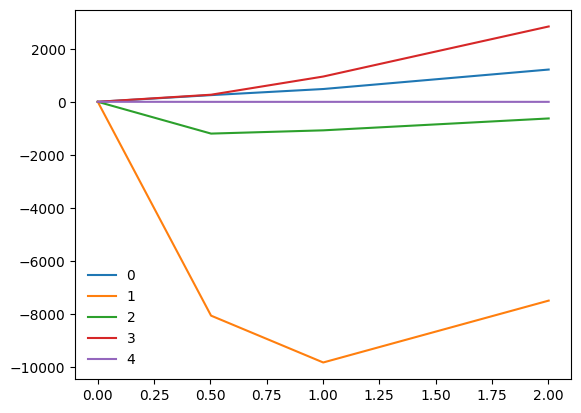

In [62]:
plt.plot(out['time'], out['totenergy0'] - out['totenergy0'][0], label='0')
plt.plot(out['time'], out['totenergy1'] - out['totenergy1'][0], label='1')
plt.plot(out['time'], out['totenergy2'] - out['totenergy2'][0], label='2')
plt.plot(out['time'], out['totenergy3'] - out['totenergy3'][0], label='3')
plt.plot(out['time'], out['totenergy4'] - out['totenergy4'][0], label='4')
plt.legend(frameon=False)

In [63]:
out['totenergy0'] + out['totenergy1'] + out['totenergy2'] + out['totenergy3'] + out['totenergy4'] 

array([-850791.5625    , -859538.17773771, -860265.78651428,
       -854862.25555551])

In [73]:
sn = sn_dict[bt][400]
np.sum(sn.part0.CoolingHeatingEnergy)

0.0

In [74]:
np.sort(sn_dict[bt][0].InternalEnergy)

Quantity([   210.48248291,    210.48248291,    210.48248291, ...,
           53113.8359375,  62200.0859375, 109645.2421875], dtype=float32, unit=[km^2 s^-2])

Text(0.5, 1.0, 'isolated')

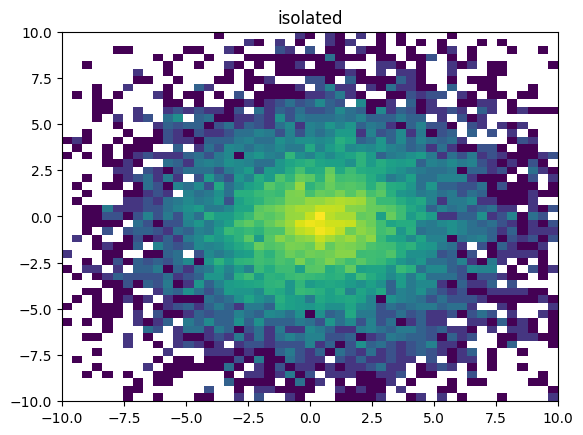

In [64]:
sn = sn_dict[bt][400]

center = 0.5 * np.array([sn.BoxSize] * 3)
pos = sn.part2.pos - center

xbins = np.linspace(-10, 10, 50)
ybins = np.linspace(-10, 10, 50)

vmin = None
vmax = None

fig, ax = plt.subplots(1, 1)
m = np.ones(len(pos))
m_in_bin, x_edge, y_edge, _ = binned_statistic_2d(pos[:,0], pos[:,1], m,
                                                  statistic='sum', bins=(xbins, ybins))

extent = [x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]]

im = ax.imshow(m_in_bin.T, origin='lower', norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), extent=extent)
ax.set_aspect('auto')
ax.set_title('isolated')

In [65]:
sn = sn_dict[bt][400]
pos = sn.part2.pos.value - 0.5*np.array([sn.BoxSize]*3)

R = np.linalg.norm(pos[:,:2], axis=1)
cphi = pos[:,0]/R
sphi = pos[:,1]/R

key = R < 5
A2r = np.sum(cphi[key])
A2i = np.sum(sphi[key])
A0 = np.sum(key)
A2 = np.sqrt(A2r*A2r + A2i*A2i)
print('A2/A0 = ', A2/A0)


A2/A0 =  0.15614719834263419


In [41]:
x_edge

array([-15.        , -14.3877551 , -13.7755102 , -13.16326531,
       -12.55102041, -11.93877551, -11.32653061, -10.71428571,
       -10.10204082,  -9.48979592,  -8.87755102,  -8.26530612,
        -7.65306122,  -7.04081633,  -6.42857143,  -5.81632653,
        -5.20408163,  -4.59183673,  -3.97959184,  -3.36734694,
        -2.75510204,  -2.14285714,  -1.53061224,  -0.91836735,
        -0.30612245,   0.30612245,   0.91836735,   1.53061224,
         2.14285714,   2.75510204,   3.36734694,   3.97959184,
         4.59183673,   5.20408163,   5.81632653,   6.42857143,
         7.04081633,   7.65306122,   8.26530612,   8.87755102,
         9.48979592,  10.10204082,  10.71428571,  11.32653061,
        11.93877551,  12.55102041,  13.16326531,  13.7755102 ,
        14.3877551 ,  15.        ])

# check pressure of snapshot 0

In [95]:
sn         = arepo.Snapshot(basepath + 'runs/MW5iso/lvl5-beta05/output', 0, combineFiles=True)
snadi      = arepo.Snapshot(basepath + 'runs/MW5iso/lvl5-beta05-adi/output', 0, combineFiles=True)
snadi_eEOS = arepo.Snapshot(basepath + 'runs/MW5iso/lvl5-beta05-adi-softEOS/output', 0, combineFiles=True)

In [108]:
key = np.argsort(sn.part0.id)
press = sn.part0.InternalEnergy[key]

key = np.argsort(snadi.part0.id)
press_adi = snadi.part0.InternalEnergy[key]
# print(snadi.part0.Pressure[key][:10])
k = np.argmax(np.abs((press-press_adi)/press))
print(press[k], press_adi[k])

210.48248 210.48248291015807


In [107]:
np.max(sn.part0.Density.value)

0.12243596

In [109]:
snadi_200      = arepo.Snapshot(basepath + 'runs/MW5iso/lvl5-beta05-adi/output', 200, combineFiles=True)
print(np.max(snadi_200.part0.Density.value))

0.001237207848053048


## old lvl4 iso adiabatic run

In [137]:
sn0 = arepo.Snapshot(basepath + 'runs/MW4iso_fg0.2_MHG0.25_RC9/lvl4-adiabatic/output', 0, combineFiles=True)
sn400 = arepo.Snapshot(basepath + 'runs/MW4iso_fg0.2_MHG0.25_RC9/lvl4-adiabatic/output', 895, combineFiles=True)

In [138]:
prof0 = gas_profile(sn0, dr=2.0)
prof400 = gas_profile(sn400, dr=2.0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1, 100)

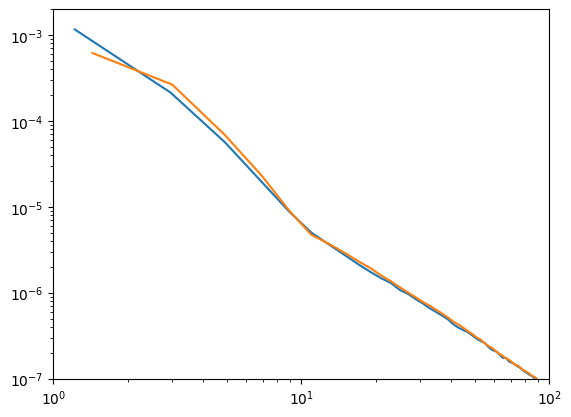

In [139]:
plt.plot(prof0['rlist'], prof0['rholist'])
plt.plot(prof400['rlist'], prof400['rholist'])

plt.legend(frameon=False)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-7, 2e-3)
plt.xlim(1, 100)

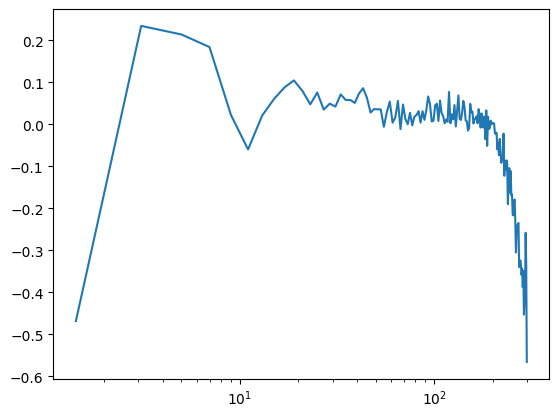

In [140]:
y = (prof400['rholist'] - prof0['rholist'])/prof0['rholist']
plt.plot(prof[bt][idx]['rlist'], y, label=bt)
plt.xscale('log')

# check temperature

In [149]:
def get_n_T(sn):
    UnitLength = sn.parameters.UnitLength_in_cm
    UnitMass = sn.parameters.UnitMass_in_g
    UnitVelocity = sn.parameters.UnitVelocity_in_cm_per_s

    UnitTime = UnitLength / UnitVelocity
    UnitEnergy = UnitMass * UnitVelocity**2

    HYDROGEN_MASSFRAC = 0.76
    GAMMA = 5./3.
    PROTONMASS = 1.67262178e-24
    BOLTZMANN = 1.38065e-16

    InternalEnergy = sn.part0.InternalEnergy.value
    if hasattr(sn.part0, 'ElectronAbundance'):
        ElectronAbundance = sn.part0.ElectronAbundance
    else:
        ElectronAbundance = np.full_like(sn.part0.Density.value, (2+5*HYDROGEN_MASSFRAC)/(4*HYDROGEN_MASSFRAC))
        
    Density = sn.part0.Density.value
    
    mu = 4 * PROTONMASS / (1 + 3 * HYDROGEN_MASSFRAC + 4 * HYDROGEN_MASSFRAC * ElectronAbundance)
    T = (GAMMA - 1.) * (InternalEnergy / BOLTZMANN) * (UnitEnergy / UnitMass) * mu

    n = Density / mu
    n *= UnitMass/UnitLength**3
    
    return n, T

In [154]:
_, T = get_n_T(sn0)

In [164]:
cen = 0.5 * np.array([sn0.BoxSize] * 3)
r = np.linalg.norm(sn0.part0.pos - cen, axis=1)
np.min(np.log10(T[r<1]))
print(r[np.argmin(T)])

1.3479474439839363


In [165]:
np.unique(np.log10(T[r<2]), return_counts=True)

(array([3.87441299, 3.87441299, 3.87441299, 3.87441299, 3.87441299,
        6.00477568, 6.02075133, 6.02509284, 6.02627891, 6.02666099,
        6.02862603, 6.02906138, 6.03342286, 6.0341142 , 6.03768931,
        6.0382532 , 6.04685038, 6.047114  , 6.05087357, 6.06155977,
        6.06161055, 6.06836143, 6.06856486, 6.07827581, 6.0803126 ,
        6.08361094, 6.08479177, 6.08530215, 6.08572831, 6.09010934,
        6.09112724, 6.10070042, 6.10289052, 6.11123169, 6.11417329,
        6.12886621, 6.1324932 , 6.1398984 , 6.15523027, 6.16089009,
        6.16113743, 6.17539156, 6.17931377, 6.18054251, 6.19541965,
        6.20129892, 6.20398492, 6.24365283, 6.25345361, 6.29553874,
        6.31391049, 6.32593067, 6.3356034 , 6.40159239, 6.60485549]),
 array([ 396,    2, 5654,    1,  376,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,   

In [168]:
from scipy.spatial import ConvexHull
pts = np.random.rand(100, 3)
hull = ConvexHull(pts)

# 2D density slices

In [219]:
import numpy as np
from scipy.spatial import KDTree
import arepo
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from types import SimpleNamespace

In [220]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r'\usepackage{amsmath}')
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27

In [221]:
def create_grid(N, L):
    """
    Create a grid of points in a plane.

    Parameters:
    - N: number of points per side
    - L: side half-length

    Returns:
    - A numpy array of shape (N*N, 3) containing the grid points.
    """
    # Create a linear space from -L to L with N points for both x and y dimensions
    x = np.linspace(-L, L, N)
    y = np.linspace(-L, L, N)

    # Create a meshgrid from the x and y arrays
    xx, yy = np.meshgrid(x, y)

    # Flatten the xx and yy arrays and stack them with a zeros array for the z coordinates
    z = np.zeros_like(xx).flatten()
    grid = np.vstack((xx.flatten(), yy.flatten(), z)).T

    return grid

In [270]:
def get_n_T(sn):
    UnitLength = sn.parameters.UnitLength_in_cm
    UnitMass = sn.parameters.UnitMass_in_g
    UnitVelocity = sn.parameters.UnitVelocity_in_cm_per_s

    UnitTime = UnitLength / UnitVelocity
    UnitEnergy = UnitMass * UnitVelocity**2

    HYDROGEN_MASSFRAC = 0.76
    GAMMA = 5./3.
    PROTONMASS = 1.67262178e-24
    BOLTZMANN = 1.38065e-16

    InternalEnergy = sn.part0.InternalEnergy.value
    if hasattr(sn.part0, 'ElectronAbundance'):
        ElectronAbundance = sn.part0.ElectronAbundance
    else:
        ElectronAbundance = np.full_like(sn.part0.Density.value, (2+5*HYDROGEN_MASSFRAC)/(4*HYDROGEN_MASSFRAC))
        
    Density = sn.part0.Density.value
    
    mu = 4 * PROTONMASS / (1 + 3 * HYDROGEN_MASSFRAC + 4 * HYDROGEN_MASSFRAC * ElectronAbundance)
    T = (GAMMA - 1.) * (InternalEnergy / BOLTZMANN) * (UnitEnergy / UnitMass) * mu

    n = Density / mu
    n *= UnitMass/UnitLength**3
    
    return n, T

In [338]:
o = SimpleNamespace()

In [340]:
o.snadi_old = {}
o.snadi = {}
o.tree = {}
# o.idxs = np.arange(0, 2000+1, 100)
o.idxs = np.array([0, 1, 2, 3, 4])
for idx in tqdm(o.idxs):
    o.snadi_old[idx] = arepo.Snapshot(basepath + 'runs/MW6iso/lvl5-beta08-adi/output', idx, combineFiles=True)
    # fname = basepath + 'runs/MW6iso/lvl5-beta067-adi/output/snapshot_potupdated_'
    # fname += str(idx).zfill(3) + '.hdf5'
    # o.snadi[idx] = arepo.Snapshot(fname)
    o.snadi[idx] = arepo.Snapshot(basepath + 'runs/MW6iso/lvl5-beta08-adi-dens/output', idx, combineFiles=True)
    o.tree[idx]  = KDTree(o.snadi[idx].part0.pos.value)

o.center = 0.5 * np.array([o.snadi[o.idxs[0]].BoxSize.value] * 3)

100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


In [341]:
# disk parameters
# o.H = 1.99582
# o.z0 = 0.45 * o.H
# o.M_DISK = 0.015 * (1 - 0.2) * 49.9148

# corona parameters
o.RHO0 = 8.05841e-05
o.RC = 9
o.BETA = 0.8

In [342]:
o.N = 1000
o.H = 1.99582
o.L = 5*o.H
o.grid = create_grid(o.N, o.L)
o.r = {}
o.key = {}
o.center = np.array([o.snadi[o.idxs[0]].BoxSize/2.]*3)
for idx in tqdm(o.idxs):
    o.r[idx], o.key[idx] = o.tree[idx].query(o.grid + o.center)
    o.key[idx] = np.reshape(o.key[idx], (o.N, o.N))

100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


AttributeError: 'types.SimpleNamespace' object has no attribute 'z0'

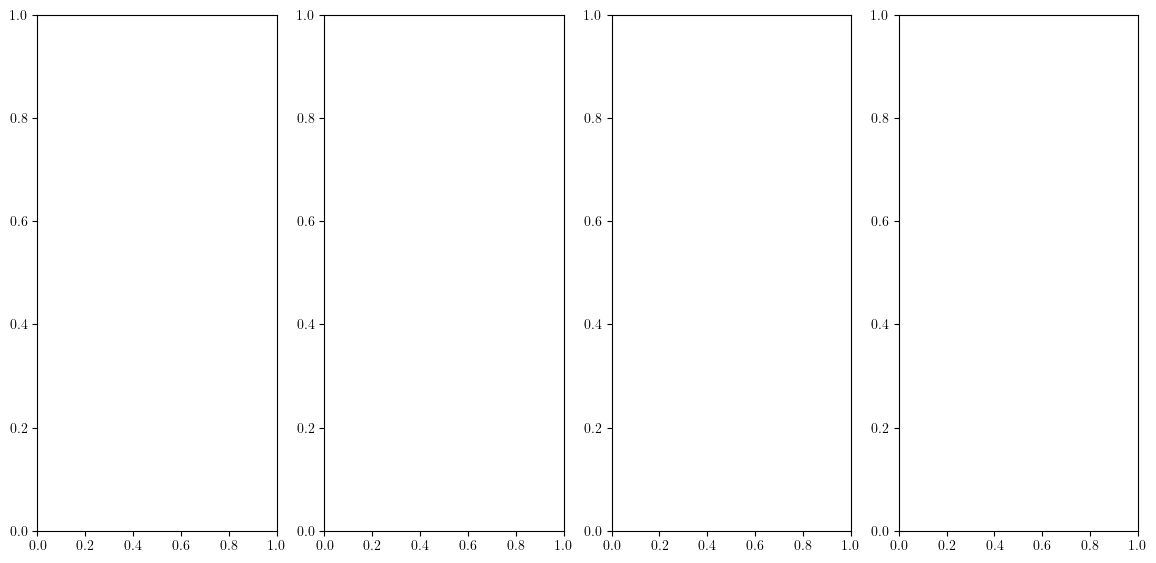

In [247]:
fig, axs = plt.subplots(1, 4, figsize=(2*textwidth, 2*columnwidth))
vmin = 0.02
vmax = 10
for i,ax in enumerate(axs):
    idx = o.idxs[i]
    sn, key = o.snadi[idx], o.key[idx]
    
    H = o.H
    z0 = o.z0
    M_DISK = o.M_DISK
    
    pos = sn.part0.CenterOfMass.value - o.center
    R = np.linalg.norm(pos[:,:2], axis=1)
    z = pos[:,2]
    
    rho_exp = (M_DISK / (4*np.pi*z0*H**2)) * (1/np.cosh(z/(2*z0))**2) * np.exp(-R/H)
    rho_exp = rho_exp[key]
    
    rho = sn.part0.rho.value[key]
    # print(np.percentile(rho/rho_exp, 10), np.percentile(rho/rho_exp, 50), np.percentile(rho/rho_exp, 90))
    print(np.min(rho/rho_exp), np.max(rho/rho_exp))
    extent = [-o.L, o.L, -o.L, o.L]
    im=ax.imshow((rho/rho_exp).T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
    # print(im.get_clim())
    
fig.tight_layout()

785
758
760
761


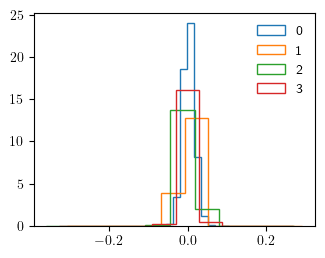

In [345]:
fig, ax = plt.subplots(1, 1, figsize=(columnwidth, 0.8*columnwidth))

r0 = 50
dr = 1

for i in [0, 1, 2, 3]:
    idx = o.idxs[i]
    sn = o.snadi[idx]
    snold = o.snadi_old[idx]
    
    n, T = get_n_T(sn)
    
    pos = sn.part0.CenterOfMass.value - o.center
    r = np.linalg.norm(pos, axis=1)
    key = np.logical_and(r > r0 - dr/2., r < r0 + dr/2.)
    print(np.sum(key))
    
    rho_exp = o.RHO0 * (1 + (r/o.RC)**2)**(-1.5*o.BETA)
    rho = sn.part0.rho.value
    
    # print(np.median(rho[key]), np.median(n[key]))
    
    # ax.hist(rho[key], density=True, label=str(idx), histtype='step')
    ax.hist((rho-rho_exp)/rho_exp, density=True, label=str(idx), histtype='step')

# ax.set(yscale='log')
ax.legend(frameon=False)
fig.tight_layout()

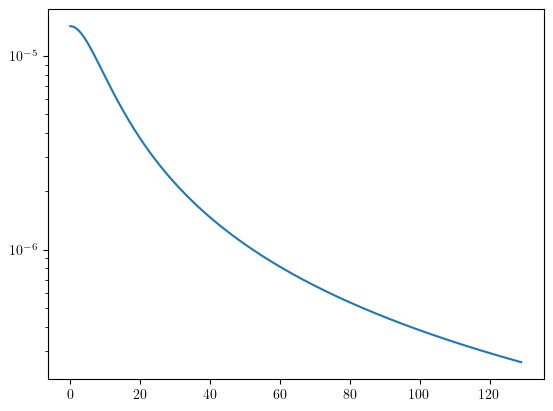

In [266]:
rlist = np.linspace(0, 129, 1000)
rholist = o.RHO0 * (1 + (rlist/o.RC)**2)**(-1.5*o.BETA)
plt.plot(rlist, rholist)
# plt.xscale('log')
plt.yscale('log')

In [275]:
sn = o.snadi[0]
R200 = 129
center = np.array([sn.BoxSize]*3)/2
r0 = np.linalg.norm(sn.part0.pos - center, axis=1)
r1 = np.linalg.norm(sn.part1.pos - center, axis=1)
M200_part0 = np.sum(sn.part0.mass[r0 < R200])
M200_part1 = sn.MassTable[1] * np.sum(r1 < R200)
print('M200(part0)=', M200_part0)
print('M200(part1)=', M200_part1)
print('bary frac=', M200_part0 / (M200_part0 + M200_part1))

M200(part0)= 4.571904161712155
M200(part1)= 24.51072
bary frac= 0.15720397637745345


In [282]:
k = np.argmin(np.abs(r0 - 50))
rho = sn.part0.rho.value[k]
m = sn.part0.mass.value[k]
print(m)
vol = m/rho
size = (3/(4*np.pi))*vol**(1/3)
print(size)

4.8000001697801054e-05
0.029879227975736007


In [286]:
sn.part0.Density[k]

0.02448315 0.00067699 cm^-3 t

In [288]:
snold = o.snadi_old[0]
snold.part0.Density[k]

3.16948214e-08 0.00067699 cm^-3 t

In [299]:
snold = arepo.Snapshot(basepath + 'runs/MW6iso/lvl5-beta067-adi/output', 0, combineFiles=True)
fname = basepath + 'runs/MW6iso/lvl5-beta067-adi/output/snapshot_potupdated_'
fname += str(0).zfill(3) + '.hdf5'
sn = arepo.Snapshot(fname)

In [300]:
for fld in ['Acceleration', 'Coordinates', 'Density', 'InternalEnergy', 'Masses', 
            'ParticleIDs', 'Potential', 'Pressure', 'Softenings', 'Velocities']:
    if hasattr(sn.part0, fld):
        fld_old = getattr(snold.part0, fld)
        fld_old = fld_old[np.argsort(snold.part0.id)]
        
        fld_new = getattr(sn.part0, fld)
        fld_new = fld_new[np.argsort(sn.part0.id)]
        
        if np.array_equal(fld_old, fld_new):
            print(fld, ': passed')
        else:
            max_dev = np.max(np.abs(fld_new - fld_old))
            print(fld, ': failed, max dev =', max_dev)
    
    else:
        print(fld, ': missing')

Acceleration : failed, max dev = 7.54747824955615
Coordinates : passed
Density : failed, max dev = 2.6020852139652106e-17
InternalEnergy : failed, max dev = 13448.292985400367
Masses : passed
ParticleIDs : passed
Potential : failed, max dev = 41.99616014584899
Pressure : failed, max dev = 1.1534712622554515
Softenings : passed
Velocities : failed, max dev = 22.25678253173828


In [298]:
print(sn.part0.acce[0])
print(snold.part0.acce[0])

[3.11886009 3.41517457 5.41634774]
[-8.46510427 -0.95476719  2.92220597]


# MW6 iso dens ics

In [303]:
import arepo
import matplotlib.pyplot as plt

In [314]:
def gas_profile(sn, rmax=300, Rmax=40, dr=1, dR=1, zcut=3, mass_is_dens=False, center=None):
    if center is None:
        center = np.array([sn.BoxSize] * 3)/2.

    pos = sn.part0.pos - center
    r = np.linalg.norm(pos, axis=1)
    R = np.linalg.norm(pos[:,:2], axis=1)
    z = pos[:,1]
    
    rmin = 0
    
    out = {}
    out['rlist'] = []
    out['rholist'] = []
    
    while rmin < rmax:
        key = np.logical_and(r >= rmin, r < rmin + dr)
        aver = np.mean(r[key])
        
        if mass_is_dens:
            rho = np.mean(sn.part0.mass[key])
        else:
            Menc = np.sum(sn.part0.mass[key])
            vol = (4 * np.pi/3.) * ((rmin + dr)**3 - rmin**3)
            rho = Menc / vol
        
        out['rlist'].append(aver)
        out['rholist'].append(rho)
        
        rmin += dr
    
    for k in out.keys():
        out[k] = np.array(out[k])
    
    return out

In [334]:
# sn = arepo.Snapshot(basepath + 'ics/MW6iso/lvl5/MW-beta08.hdf5')
sn = arepo.Snapshot(basepath + 'ics/MW6iso/lvl5-dens/MW_ICs-beta08.dat')
# out = gas_profile(sn, center=0.5*np.array([1290]*3),  mass_is_dens=True)
out = gas_profile(sn, center=0.5*np.array([0]*3),  mass_is_dens=True)

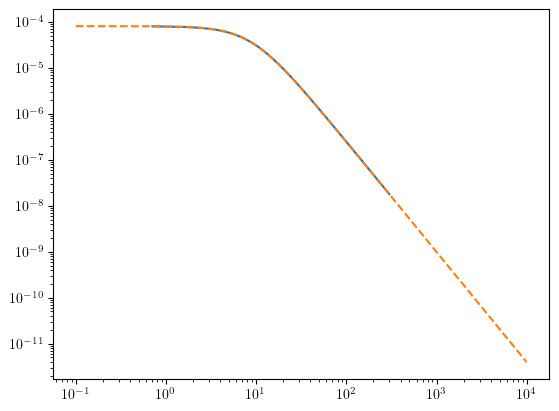

In [337]:
plt.plot(out['rlist'], out['rholist'])

RHO0 = 8.05841e-05
RC = 9
BETA = 0.8

rlist = np.logspace(-1, 4, 10000)
rholist = RHO0 * (1 + (rlist/RC)**2)**(-1.5*BETA)
plt.plot(rlist, rholist, ls='dashed')

plt.xscale('log')
plt.yscale('log')

In [331]:
sn.part0.mass

array([40., 39., 40., ..., 40., 40., 40.], dtype=float32)